In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.contrib.layers as layers
import seaborn as sns

In [2]:
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
from flows import NVPFlow, FlowSequence, ResFlow, BNFlow, phase, floatX, Normalizer

In [3]:
inp = tf.placeholder(floatX, [None, 2])

In [4]:
# flow = ResFlow(2, 'res_init', normalize=False)(inp)
flow = NVPFlow(2, name='nvp_init', normalize=False)(inp)

for i in range(0, 9):
#     flow = ResFlow(name='res_' + str(i), normalize=False)(flow)
    flow = NVPFlow(name='nvp_' + str(i), normalize=False)(flow)

In [5]:
flow[-1].output /= 2

In [6]:
flow[-1].logj.shape

TensorShape([Dimension(None)])

In [7]:
flows = flow

In [8]:
logj = flows.calc_logj()

In [9]:
logj

<tf.Tensor 'add_10:0' shape=(?,) dtype=float64>

In [10]:
mm = np.zeros(2, np.int)
for fl in flows:
    if hasattr(fl, 'mask'):
        mm += fl.mask
        print(fl.mask)

[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]
[ True False]
[False  True]


In [11]:
mm

array([5, 5])

In [12]:
with tf.name_scope('gain_scope'):
    z = flows[-1].output
    gain = tf.reduce_sum(-(z*z)/2, axis=-1) + logj
    gain = tf.reduce_mean(gain)

In [13]:
lr = tf.Variable(0.001, trainable=False, name='learning_rate')
train_op = tf.train.AdamOptimizer(lr).minimize(-gain)
train_op = [train_op] + flows.get_ops()

In [14]:
X, _ = make_moons(n_samples=4024, noise=0.13)

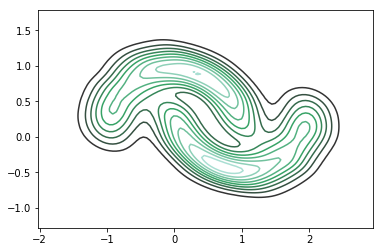

In [15]:
sns.kdeplot(X[:,0], X[:,1], kernel='tri')
plt.show()

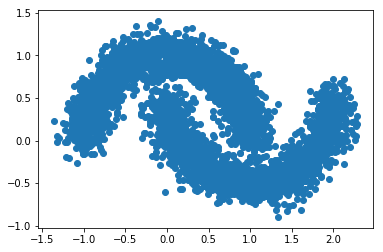

In [16]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [17]:
sess = tf.InteractiveSession()

In [18]:
tf.global_variables_initializer().run()

In [19]:
logj.eval({inp:X, phase: False}).mean()

-0.008002998408016982

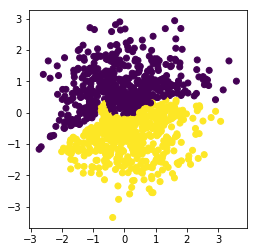

In [26]:
X, y = make_moons(n_samples=1024, noise=0.13)
ver = z.eval({inp:X, phase:False})

ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(ver[:,0], ver[:,1], c=y)
plt.show()

In [21]:
# sess.run(lr.assign(0.0001))

In [22]:
!rm -R /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [23]:
writer.add_graph(tf.get_default_graph())

In [24]:
all_sum = tf.summary.merge_all()

In [25]:
for _ in range(80):
    for _ in range(300):
        X, _ = make_moons(n_samples=256, noise=0.13)
        sess.run(train_op, {inp:X, phase:True})
    print(gain.eval({inp:X, phase: True}))
    #writer.add_summary(all_sum.eval({inp:X, phase:True}))

1.2941179217974188
1.2441291091484412
1.304770290424797
1.470282100242655
1.570562822493085
1.594752789166698
1.658288046235742
1.6435440979086158
1.744258011091743
1.7126284903325706
1.7867138437615169
1.6954818807754806
1.7910070094223964
1.629292240034974
1.779619492509079
1.750396277970638
1.8200035722000532
1.7711669989230665
1.7612731449680337
1.7872367130385651
1.79337969837185
1.7636027173471494
1.7741625020623728
1.7784162636040666
1.803576744480158
1.7137517893313725
1.790259521344944
1.7821341972471405
1.818158597631924
1.7877760282473303
1.809689008491747
1.8139258487477032
1.816867346783129
1.7346960169986818
1.8054688879202843
1.7282995679255322
1.8506567307289323
1.7978135419702415
1.8246119298199233
1.760994819221339
1.7977705219416107
1.89271153455995
1.786245540281199
1.853480291639163
1.8095548261027612
1.8376447077508589
1.8730041815526108
1.7771745436299984
1.8406080846829822
1.836717291553449
1.8256353695008842
1.8479592496293775
1.8712007163168272
1.8969472068752

In [27]:
inverse = flows.apply(inp*2, inverse=True)

In [28]:
restored = inverse.eval({inp:np.random.normal(size=[1000,2]), phase: False})
#restored = inverse.eval({inp:ver})

In [29]:
restored = restored[np.logical_not(np.any(restored**2 > 30, axis=-1))]

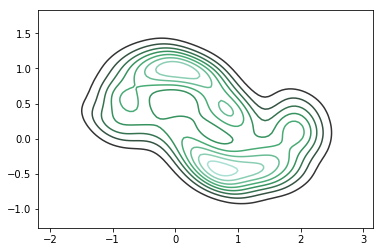

In [30]:
sns.kdeplot(restored[:,0], restored[:,1])
plt.show()

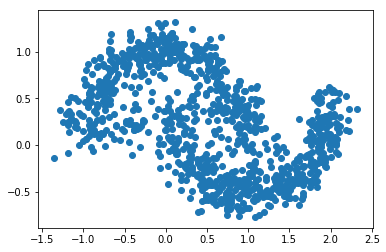

In [31]:
plt.scatter(restored[:,0], restored[:,1])
plt.show()